In [2]:
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import h5py
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

In [5]:
import shutil

In [6]:
import os

In [7]:
import bilby

12:36 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
12:36 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
12:36 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.


In [8]:
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams.update({'font.size': 16})

In [9]:
import numpy as np

# try fitting NR frequency data

In [10]:
def compute_integral(times, x, npts=None):
    """
    times = array of independent variable
    x = array of dependent variable
    npts = None (default to len(times)) number o fpoints to resample to integrate
    """
    
    if npts is None:
        npts = len(times)*2

    ix = IUS(times,  x)

    t1 = times[0]
    t2 = times[-1]
    res = []
    dt = times[1] - times[0]
    tss = np.linspace(t1+dt, t2, 1000)
    for ts in tss: 
        res.append(scipy.integrate.quad(ix, t1, ts)[0])
    res = np.array(res)

    ires = IUS(tss, res)
    return ires(times)

In [11]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [12]:
def planck_taper(times, t1, t2):
    """times: array of times
    t1. for t<=t1 then return 0
    t2. for t>=t2 then return 1
    else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
    tout = []
    for t in times:
        if t<=t1:
            tout.append(0.)
        elif t>=t2:
            tout.append(1.)
        else:
            tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
    return np.array(tout)

In [13]:
# Newton gravity constant
# lal.G_SI: 6.67384e-11
G_Newt = 6.67384e-11

In [14]:
# light speed
# lal.C_SI: 299792458.0
c_ls = 299792458.0

In [15]:
# lal.MSUN_SI: 1.9885469549614615e+30
MSUN_SI = 1.9885469549614615e+30

In [16]:
MTSUN_SI = 4.925491025543576e-06

In [17]:
# lal.MRSUN_SI: 1476.6250614046494
MRSUN_SI = 1476.6250614046494

In [18]:
# lal.PC_SI: 3.085677581491367e+16
PC_SI = 3.085677581491367e+16

In [19]:
# lal.GAMMA: 0.5772156649015329
GAMMA = 0.5772156649015329

In [20]:
def Msun_to_sec(M):
    """
    convert mass (in units of solar masses)
    into seconds
    """
#     return M *lal.MSUN_SI* G_Newt / c_ls**3.
    return M * MTSUN_SI

In [21]:
def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in Mpc
    M*G/c^2 * M_sun / dist
    """
    return mtot * MRSUN_SI / (distance * 1e6*PC_SI)

In [22]:
def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio
    input: q
    output: eta
    """
    return q/(1.+q)**2

In [23]:
class MultiModeNRWaveform(object):
    def __init__(self, nrfile, ell_mm_list, npts, t1=-600, t2=60):
        """
        ell_mm_list e.g. [(2,2), (3,2)]
        """

        self.nrfile = nrfile
        self.npts = npts
        self.t1=t1
        self.t2=t2
        self.ell_mm_list = ell_mm_list

        self.times = np.linspace(self.t1, self.t2, self.npts)
        
        self.get_lm_modes(self.nrfile, self.ell_mm_list, self.npts)


    def get_lm_modes(self, nrfile, ell_mm_list, npts):
        
        self.hlms = {}
        
        for ell, mm in ell_mm_list:

            if '.h5' in nrfile:
                f = h5py.File(nrfile, 'r')

                self.q = f.attrs['mass1']/f.attrs['mass2']
                self.eta = f.attrs['eta']

                amp_tmp = f['amp_l{0}_m{1}'.format(ell, mm)]
                amp_x = amp_tmp['X'][:]
                amp_y = amp_tmp['Y'][:]

                phase_tmp = f['phase_l{0}_m{1}'.format(ell, mm)]
                phase_x = phase_tmp['X'][:]
                phase_y = phase_tmp['Y'][:]

                f.close()
            else:
                # bam
                self.sim_dir = os.path.dirname(nrfile)
                self.bbh_file = glob.glob( os.path.join(self.sim_dir, '*.bbh') )[0]
                # strict=False because of DuplicateSectionError
                config = configparser.ConfigParser(strict=False)

                config.read(self.bbh_file)
                mass1_tmp = float(config['metadata']['mass1'])
                mass2_tmp = float(config['metadata']['mass2'])
                self.initial_sep = float(config['metadata']['initial-separation'])

                if mass1_tmp >= mass2_tmp:
                    mass1 = mass1_tmp
                    mass2 = mass2_tmp
                else:
                    mass1 = mass2_tmp
                    mass2 = mass1_tmp


                self.mass1 = mass1
                self.mass2 = mass2
                self.mtot = self.mass1 + self.mass2
                self.q = self.mass1 / self.mass2
                self.eta = self.mass1 * self.mass2 / (self.mtot)**2.

                times, re_hlm, im_hlm = np.loadtxt(nrfile, unpack=True)

                # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
                hlm = re_hlm - 1.j * im_hlm

                amp_x = times
                amp_y = np.abs(hlm)

                phase_x = times
                phase_y = np.unwrap(np.angle(hlm))


            if (ell == 2) & (mm == 2):
                # shift so that amp peak is at t=0 - will need to be more careful with HMs
                amp_peak_idx_22 = amp_y.argmax()
                amp_peak_time_22 = amp_x[amp_peak_idx_22]
                amp_x = amp_x - amp_peak_time_22
                phase_x = phase_x - amp_peak_time_22
            else:
                amp_x = amp_x - amp_peak_time_22
                phase_x = phase_x - amp_peak_time_22


            amp_i = IUS(amp_x, amp_y)
            phase_i = IUS(phase_x, phase_y)          

            amplist = amp_i(self.times)
            
            # align phase s.t. at t=10 after peak of 22 stran the phase is zeri
#             phi_0 = phase_i(10)
#             phase_i = IUS(phase_x, phase_y - phi_0)
            phaselist = phase_i(self.times)
            
            freqlist = phase_i.derivative()(self.times)

            
            amp = amplist
            phi = phaselist
            freq = freqlist
            hlm = amp * np.exp(-1.j * phi)
            
            hlm_dict = {
                'times':self.times,
                'amp':amp,
                'phi':phi,
                'hlm':hlm,
                'freq':freq
            }
            
            self.hlms.update({(ell,mm):hlm_dict})
            
        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        

    def resample_data(self, new_time_array):
        """
        new_time_array : numpy.array

        redefines the amp, phi and hlm attributes to be sampled on
        the new_time_array
        """
        amp_i = IUS(self.times, self.amp)
        phi_i = IUS(self.times, self.phi)

        self.npts = len(new_time_array)
        self.times = new_time_array
        self.amp = amp_i(new_time_array)
        self.phi = phi_i(new_time_array)
        self.hlm = self.amp * np.exp(-1.j * self.phi)


In [24]:
# lets load a few resolutions of the same case to get uncertainty

In [25]:
nrfiles = dict(
        q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
        q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
        q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
        q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
        q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
        q18="/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5",
    )

# nrfiles = dict(
#     q10_3 = '/Users/spx8sk/work/data/SXS_BBH_0303_Res3.h5',
#     q10_4 = '/Users/spx8sk/work/data/SXS_BBH_0303_Res4.h5',
#     q10_5 = '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5'
# )


# ell_mm_list = [(2,2),(3,2)]
ell_mm_list = [(2,2)]
npts_time = 1000*4

nrdatas = {}

for k in nrfiles.keys():
    nrfile = nrfiles[k]
    nrdatas.update({k:MultiModeNRWaveform(nrfile, ell_mm_list, npts_time, t1=-600,t2=100)})

In [26]:
mode = (2,2)
plt.figure()
plt.plot(nrdatas['q10'].hlms[mode]['times'], nrdatas['q10'].hlms[mode]['freq'])
plt.xlim(-100,100)
plt.ylim(-1,0)

(-1, 0)

## fit MRD freq using nest

In [27]:
mode = (2,2)
x = nrdatas['q10'].hlms[mode]['times']
y = nrdatas['q10'].hlms[mode]['freq']

mask = (x > -20) & (x < 40)
x = x[mask]
y = y[mask]


In [28]:
omf = -nrdatas['q10'].fring*2*np.pi

In [29]:
tau = 1./nrdatas['q10'].fdamp/2/np.pi

In [30]:
# A few simple setup steps
# label = 'test_q10_emcee'
# outdir = 'test_q10_emcee'

# label = 'test_q10_ptemcee'
# outdir = 'test_q10_ptemcee'

label = 'test_q10_dynesty'
outdir = 'test_q10_dynesty'

shutil.rmtree(outdir)

bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)

# First, we define our "signal model", in this case a simple linear function
def model(x, a, omf, t0, kappa, tau):
    dt = x - t0
    num = 1. + np.tanh((dt/tau))
    den = 2.
    ansatz = a + (omf - a) * ((num/den)**(kappa))
    return ansatz

# N = len(x)
# sigma = np.random.normal(1, 0.001, N)

# We quickly plot the data to check it looks sensible
fig, ax = plt.subplots()
# ax.plot(x, y + sigma, 'o', label='data')
ax.plot(x, y, 'o', label='data')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
fig.savefig('{}/{}_data.png'.format(outdir, label))

# Now lets instantiate a version of our GaussianLikelihood, giving it
# the time, data and signal model
likelihood = bilby.likelihood.GaussianLikelihood(x, y, model, sigma=None)

# From hereon, the syntax is exactly equivalent to other bilby examples
# We make a prior
priors = dict()

priors['a'] = bilby.core.prior.Uniform(-1, 1, 'a')
priors['t0'] = bilby.core.prior.Uniform(-40, 40, 't0')
priors['kappa'] = bilby.core.prior.Uniform(0.1, 0.8, 'kappa')
# priors['kappa'] = bilby.core.prior.DeltaFunction(0.25, 'kappa')

# priors['omf'] = bilby.core.prior.Uniform(omf-0.1, omf+0.1, 'omf')
priors['omf'] = bilby.core.prior.DeltaFunction(omf, 'omf')

# priors['tau'] = bilby.core.prior.Uniform(tau-2, tau+2, 'tau')
priors['tau'] = bilby.core.prior.DeltaFunction(tau, 'tau')

priors['sigma'] = bilby.core.prior.LogUniform(1e-5, 1, 'sigma')


# And run sampler
# result = bilby.run_sampler(
#     likelihood=likelihood, priors=priors, sampler='ptemcee',
#     nwalkers=500, nsteps=500, nburn=100, ntemps=4,
#     outdir=outdir,
#     label=label)
# result.plot_corner()

result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty',
    nlive=100,
    outdir=outdir,
    label=label)
result.plot_corner()


12:36 bilby INFO    : Running for label 'test_q10_dynesty', output will be saved to 'test_q10_dynesty'
12:36 bilby INFO    : Search parameters:
12:36 bilby INFO    :   a = Uniform(minimum=-1, maximum=1, name='a', latex_label='a', unit=None, boundary=None)
12:36 bilby INFO    :   t0 = Uniform(minimum=-40, maximum=40, name='t0', latex_label='t0', unit=None, boundary=None)
12:36 bilby INFO    :   kappa = Uniform(minimum=0.1, maximum=0.8, name='kappa', latex_label='kappa', unit=None, boundary=None)
12:36 bilby INFO    :   sigma = LogUniform(minimum=1e-05, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
12:36 bilby INFO    :   omf = -0.4158438649801314
12:36 bilby INFO    :   tau = 11.272552160962043
12:36 bilby INFO    : Single likelihood evaluation took 1.464e-04 s


0it [00:00, ?it/s]

12:36 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 40, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x10bb048d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None}
12:36 bilby INFO    : Checkpoint every n_check_point = 4000000
12:36 bilby INFO    : Using dynesty version 1.0.0


2782it [00:30, 106.95it/s, bound:1203 ncall:99984 eff:2.8% logz=1848.46+/-0.68 dlogz:0.104>0.10]

12:36 bilby INFO    : Writing checkpoint file test_q10_dynesty/test_q10_dynesty_resume.pickle



2785it [00:31, 89.76it/s, bound:1205 ncall:100104 eff:2.9% logz=1848.54+/-0.69 dlogz:0.001>0.10]

12:36 bilby INFO    : Sampling time: 0:00:30.351901


12:36 bilby INFO    : Summary of results:
nsamples: 2885
log_noise_evidence:    nan
log_evidence: 1848.537 +/-  0.687
log_bayes_factor:    nan +/-  0.687



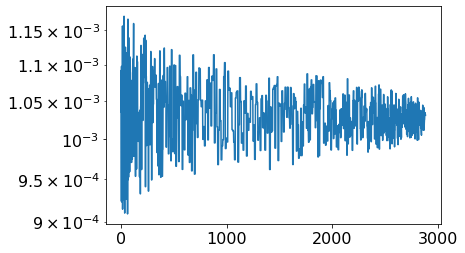

In [31]:
plt.figure()
plt.plot(result.posterior['sigma'])
plt.yscale('log')

In [32]:
plt.figure()
plt.plot(result.posterior['omf'])
plt.axhline(omf, c='k')

In [33]:
plt.figure()
plt.plot(result.posterior['tau'])
plt.axhline(tau, c='k')

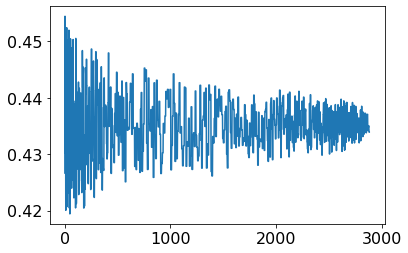

In [34]:
plt.figure()
plt.plot(result.posterior['kappa'])

In [35]:
maxL = result.posterior.iloc[result.posterior.log_likelihood.idxmax()]
print(maxL)

a                   -0.173449
t0                   7.967281
kappa                0.433909
sigma                0.001031
omf                 -0.415844
tau                 11.272552
log_likelihood    1873.915271
log_prior           -0.284658
Name: 2882, dtype: float64


In [36]:
maxL_params = maxL.copy()
maxL_params.pop('log_likelihood')
maxL_params.pop('log_prior')
maxL_params.pop('sigma')

0.0010309118130499742

In [37]:
maxL_prediction = model(x, **maxL_params)

In [38]:
plt.figure()
plt.scatter(x, y, label='data')
plt.plot(x, maxL_prediction, c='C1', label='maxL')

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Data to fit")
plt.show()
plt.close()

In [39]:
import lmfit
from lmfit import Minimizer, Parameters, report_fit

In [40]:
class Model_Freq_MR(object):
    def __init__(self, x, y, fdamp, fring):
        self.x = x
        self.y = y
        self.fdamp = fdamp
        self.fring = fring
        
    def ansatz(self, params, t):
        
        t0 = params['t0']
        kappa = params['kappa']
        b = params['b']
        om_f = params['om_f']
        a = params['a']
        
#         c = params['c']
#         d = params['d']
#         e = params['e']

        dt = t - t0
        num = 1. + np.tanh((dt/b))
        den = 2.

        model = a + (om_f - a) * ((num/den)**(kappa))
        
        return model

    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data
        
    def fit(self, t1=-10, t2=40):

        self.mask = (self.x > t1) & (self.x < t2)
        self.fit_times = self.x[self.mask]
        self.fit_data = self.y[self.mask]
        
        # create a set of Parameters
        params = Parameters()
        params.add('t0', value=5., min=-20, max=20)
        params.add('kappa', value=0.44, vary=True)
        params.add('b', value=self.fdamp, vary=False)
        params.add('om_f', value=self.fring, vary=False)
        params.add('a', value=-0.173776, min=-1, max=1, vary=True)
        
#         params.add('c', value=0, min=-200, max=200, vary=False)
#         params.add('d', value=0, min=-200, max=200, vary=False)
#         params.add('e', value=0, min=-200, max=200, vary=False)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params,self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')

        
        plt.show()
        plt.close()

In [41]:
maxL_params

a        -0.173449
t0        7.967281
kappa     0.433909
omf      -0.415844
tau      11.272552
Name: 2882, dtype: float64

In [42]:
example_fit = Model_Freq_MR(x, y, tau, omf)
example_fit.fit(t1=-20)
example_fit.plot_result()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 343
    # variables        = 3
    chi-square         = 3.6084e-04
    reduced chi-square = 1.0613e-06
    Akaike info crit   = -4715.33011
    Bayesian info crit = -4703.81692
[[Variables]]
    t0:     7.95399414 +/- 0.06957872 (0.87%) (init = 5)
    kappa:  0.43508259 +/- 0.00489508 (1.13%) (init = 0.44)
    b:      11.27255 (fixed)
    om_f:  -0.4158439 (fixed)
    a:     -0.17367343 +/- 8.1146e-04 (0.47%) (init = -0.173776)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, a)  = -0.971
    C(t0, kappa) = -0.958
    C(t0, a)     =  0.875


In [43]:
example_fit.result.params['t0'].stderr

0.06957872117038194

In [44]:
example_fit.result.params

Parameters([('t0',
             <Parameter 't0', value=7.953994136488518 +/- 0.0696, bounds=[-20:20]>),
            ('kappa',
             <Parameter 'kappa', value=0.43508259038297625 +/- 0.0049, bounds=[-inf:inf]>),
            ('b',
             <Parameter 'b', value=11.272552160962043 (fixed), bounds=[-inf:inf]>),
            ('om_f',
             <Parameter 'om_f', value=-0.4158438649801314 (fixed), bounds=[-inf:inf]>),
            ('a',
             <Parameter 'a', value=-0.1736734305842922 +/- 0.000811, bounds=[-1:1]>)])

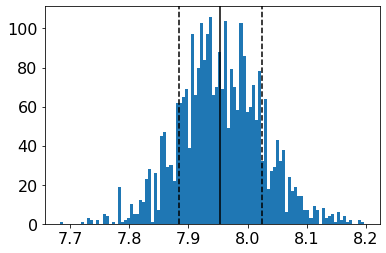

In [45]:
plt.figure()
plt.hist(result.posterior['t0'], bins=100);

v = example_fit.result.params['t0'].value
verr = example_fit.result.params['t0'].stderr

plt.axvline(v, c='k')
plt.axvline(v+verr, c='k', ls='--')
plt.axvline(v-verr, c='k', ls='--')

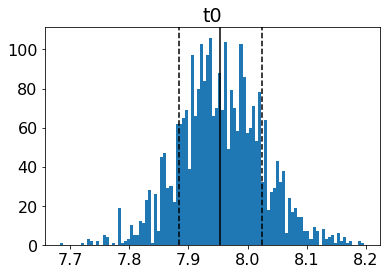

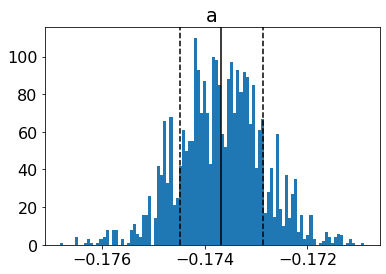

In [46]:
for p in ['t0', 'kappa', 'a']:
    plt.figure()
    plt.hist(result.posterior[p], bins=100);
    v = example_fit.result.params[p].value
    verr = example_fit.result.params[p].stderr

    plt.axvline(v, c='k')
    plt.axvline(v+verr, c='k', ls='--')
    plt.axvline(v-verr, c='k', ls='--')
    plt.title(p)
    plt.show()
    plt.close()

# loop over cases

In [47]:
mode = (2,2)
t1 = -20
t2 = 40

fit_data = {}

for k in nrdatas.keys():

    x = nrdatas[k].hlms[mode]['times']
    y = nrdatas[k].hlms[mode]['freq']

    mask = (x > t1) & (x < t2)
    x = x[mask]
    y = y[mask]
    omf = -nrdatas[k].fring*2*np.pi
    tau = 1./nrdatas[k].fdamp/2/np.pi    
    
    data = {'x':x, 'y':y, 'omf':omf, 'tau':tau}
    
    fit_data.update({k:data})

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 343
    # variables        = 3
    chi-square         = 8.5515e-05
    reduced chi-square = 2.5152e-07
    Akaike info crit   = -5209.15883
    Bayesian info crit = -5197.64564
[[Variables]]
    t0:     9.31034918 +/- 0.02165854 (0.23%) (init = 5)
    kappa:  0.44365861 +/- 0.00147500 (0.33%) (init = 0.44)
    b:      11.70642 (fixed)
    om_f:  -0.5534662 (fixed)
    a:     -0.17604967 +/- 3.6356e-04 (0.21%) (init = -0.173776)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, a)  = -0.969
    C(t0, kappa) = -0.957
    C(t0, a)     =  0.871


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 343
    # variables        = 3
    chi-square         = 2.4782e-04
    reduced chi-square = 7.2888e-07
    Akaike info crit   = -4844.20353
    Bayesian info crit = -4832.69034
[[Variables]]
    t0:     8.37063554 +/- 0.04087908 (0.49%) (init = 5)
    kappa:  0.44472983 +/- 0.00286451 (0.64%) (init = 0.44)
    b:      11.55474 (fixed)
    om_f:  -0.5224378 (fixed)
    a:     -0.17658918 +/- 6.5350e-04 (0.37%) (init = -0.173776)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, a)  = -0.970
    C(t0, kappa) = -0.958
    C(t0, a)     =  0.875


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 343
    # variables        = 3
    chi-square         = 3.8062e-04
    reduced chi-square = 1.1195e-06
    Akaike info crit   = -4697.02781
    Bayesian info crit = -4685.51461
[[Variables]]
    t0:     6.60969995 +/- 0.06326438 (0.96%) (init = 5)
    kappa:  0.44679176 +/- 0.00467549 (1.05%) (init = 0.44)
    b:      11.36517 (fixed)
    om_f:  -0.4670323 (fixed)
    a:     -0.17636792 +/- 9.2043e-04 (0.52%) (init = -0.173776)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, a)  = -0.973
    C(t0, kappa) = -0.961
    C(t0, a)     =  0.884


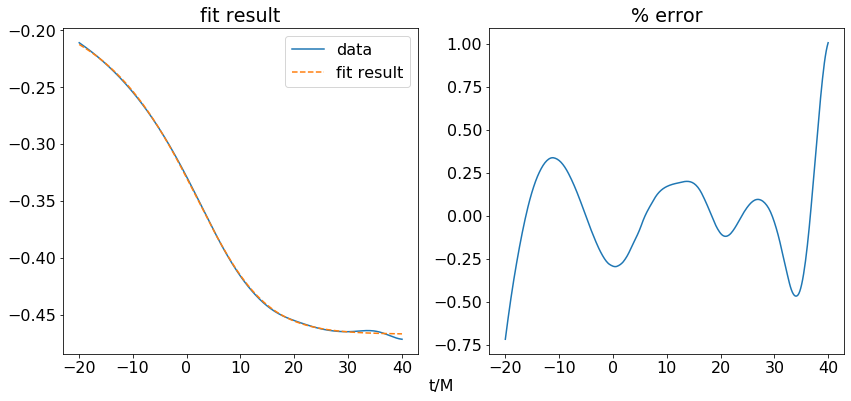

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 343
    # variables        = 3
    chi-square         = 2.3306e-04
    reduced chi-square = 6.8547e-07
    Akaike info crit   = -4865.26649
    Bayesian info crit = -4853.75329
[[Variables]]
    t0:     7.00229671 +/- 0.05111158 (0.73%) (init = 5)
    kappa:  0.44278650 +/- 0.00372111 (0.84%) (init = 0.44)
    b:      11.32931 (fixed)
    om_f:  -0.4515199 (fixed)
    a:     -0.17526408 +/- 6.9969e-04 (0.40%) (init = -0.173776)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, a)  = -0.972
    C(t0, kappa) = -0.960
    C(t0, a)     =  0.881


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 343
    # variables        = 3
    chi-square         = 3.6084e-04
    reduced chi-square = 1.0613e-06
    Akaike info crit   = -4715.33011
    Bayesian info crit = -4703.81692
[[Variables]]
    t0:     7.95399414 +/- 0.06957872 (0.87%) (init = 5)
    kappa:  0.43508259 +/- 0.00489508 (1.13%) (init = 0.44)
    b:      11.27255 (fixed)
    om_f:  -0.4158439 (fixed)
    a:     -0.17367343 +/- 8.1146e-04 (0.47%) (init = -0.173776)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, a)  = -0.971
    C(t0, kappa) = -0.958
    C(t0, a)     =  0.875


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 343
    # variables        = 3
    chi-square         = 0.00509110
    reduced chi-square = 1.4974e-05
    Akaike info crit   = -3807.47111
    Bayesian info crit = -3795.95792
[[Variables]]
    t0:     5.82417479 +/- 0.30901684 (5.31%) (init = 5)
    kappa:  0.45974926 +/- 0.02380014 (5.18%) (init = 0.44)
    b:      11.25571 (fixed)
    om_f:  -0.397943 (fixed)
    a:     -0.17929473 +/- 0.00337711 (1.88%) (init = -0.173776)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, a)  = -0.973
    C(t0, kappa) = -0.962
    C(t0, a)     =  0.885


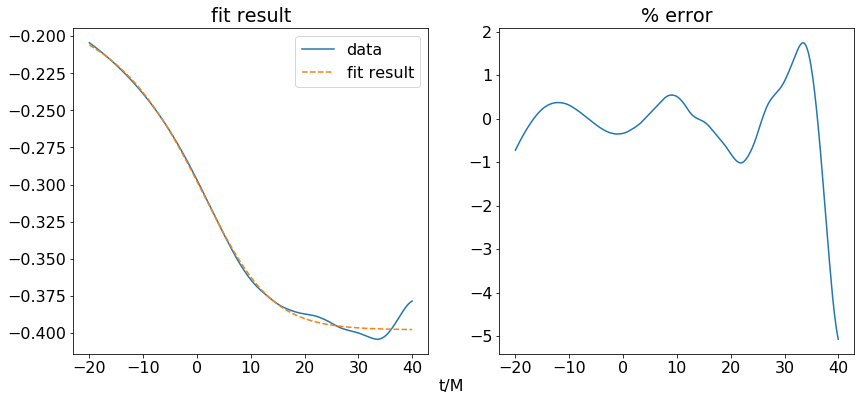

In [48]:
lmfit_results = {}

for k in fit_data.keys():
    
    x = fit_data[k]['x']
    y = fit_data[k]['y']
    omf = fit_data[k]['omf']
    tau = fit_data[k]['tau']

    fit = Model_Freq_MR(x, y, tau, omf)
    fit.fit(t1=-20)
    
    lmfit_results.update({k:fit})
    
    fit.plot_result()
    
    

In [49]:
# First, we define our "signal model", in this case a simple linear function
def model(x, a, omf, t0, kappa, tau):
    dt = x - t0
    num = 1. + np.tanh((dt/tau))
    den = 2.
    ansatz = a + (omf - a) * ((num/den)**(kappa))
    return ansatz

In [52]:
def run_bilby(fit_data, k, outdir):
    
    label = '{}_dynesty'.format(k)
    outsubdir = os.path.join(outdir, '{}_dynesty'.format(k))

#     shutil.rmtree(outsubdir)

    bilby.utils.check_directory_exists_and_if_not_mkdir(outsubdir)
    
    x = fit_data[k]['x']
    y = fit_data[k]['y']
    omf = fit_data[k]['omf']
    tau = fit_data[k]['tau']
    
    # Now lets instantiate a version of our GaussianLikelihood, giving it
    # the time, data and signal model
    likelihood = bilby.likelihood.GaussianLikelihood(x, y, model, sigma=None)

    # From hereon, the syntax is exactly equivalent to other bilby examples
    # We make a prior
    priors = dict()

    priors['a'] = bilby.core.prior.Uniform(-1, 1, 'a')
    priors['t0'] = bilby.core.prior.Uniform(-40, 40, 't0')
    priors['kappa'] = bilby.core.prior.Uniform(0.1, 0.8, 'kappa')
    # priors['kappa'] = bilby.core.prior.DeltaFunction(0.25, 'kappa')

    # priors['omf'] = bilby.core.prior.Uniform(omf-0.1, omf+0.1, 'omf')
    priors['omf'] = bilby.core.prior.DeltaFunction(omf, 'omf')

    # priors['tau'] = bilby.core.prior.Uniform(tau-2, tau+2, 'tau')
    priors['tau'] = bilby.core.prior.DeltaFunction(tau, 'tau')

    priors['sigma'] = bilby.core.prior.LogUniform(1e-5, 1, 'sigma')

    result = bilby.run_sampler(
        likelihood=likelihood, priors=priors, sampler='dynesty',
        nlive=100,
        outdir=outdir,
        label=label)
    result.plot_corner()


    return result

In [51]:
outdir = 'bilby_out'
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)

bilby_results = {}

for k in fit_data.keys():
    
    x = fit_data[k]['x']
    y = fit_data[k]['y']
    omf = fit_data[k]['omf']
    tau = fit_data[k]['tau']

    result = run_bilby(fit_data, k, outdir)

    bilby_results.update({k:result})

12:37 bilby INFO    : Running for label 'q1_dynesty', output will be saved to 'bilby_out'
12:37 bilby INFO    : Search parameters:
12:37 bilby INFO    :   a = Uniform(minimum=-1, maximum=1, name='a', latex_label='a', unit=None, boundary=None)
12:37 bilby INFO    :   t0 = Uniform(minimum=-40, maximum=40, name='t0', latex_label='t0', unit=None, boundary=None)
12:37 bilby INFO    :   kappa = Uniform(minimum=0.1, maximum=0.8, name='kappa', latex_label='kappa', unit=None, boundary=None)
12:37 bilby INFO    :   sigma = LogUniform(minimum=1e-05, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
12:37 bilby INFO    :   omf = -0.5534661793193033
12:37 bilby INFO    :   tau = 11.706422641558191
12:37 bilby INFO    : Single likelihood evaluation took 1.393e-04 s


0it [00:00, ?it/s]

12:37 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 40, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x12cdab990>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None}
12:37 bilby INFO    : Checkpoint every n_check_point = 4000000
12:37 bilby INFO    : Using dynesty version 1.0.0


2960it [00:27, 116.15it/s, bound:1299 ncall:107541 eff:2.8% logz=2093.54+/-0.71 dlogz:0.111>0.10]

12:37 bilby INFO    : Writing checkpoint file bilby_out/q1_dynesty_resume.pickle



2970it [00:28, 105.90it/s, bound:1304 ncall:107941 eff:2.8% logz=2093.63+/-0.71 dlogz:0.001>0.10]



12:37 bilby INFO    : Sampling time: 0:00:27.511855
12:37 bilby INFO    : Summary of results:
nsamples: 3070
log_noise_evidence:    nan
log_evidence: 2093.628 +/-  0.714
log_bayes_factor:    nan +/-  0.714

12:37 bilby INFO    : Running for label 'q2_dynesty', output will be saved to 'bilby_out'
12:37 bilby INFO    : Search parameters:
12:37 bilby INFO    :   a = Uniform(minimum=-1, maximum=1, name='a', latex_label='a', unit=None, boundary=None)
12:37 bilby INFO    :   t0 = Uniform(minimum=-40, maximum=40, name='t0', latex_label='t0', unit=None, boundary=None)
12:37 bilby INFO    :   kappa = Uniform(minimum=0.1, maximum=0.8, name='kappa', latex_label='kappa', unit=None, boundary=None)
12:37 bilby INFO    :   sigma = LogUniform(minimum=1e-05, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
12:37 bilby INFO    :   omf = -0.5224377894531339
12:37 bilby INFO    :   tau = 11.554740530290251
12:37 bilby INFO    : Single likelihood evaluation took 1.029e-04 s


0it [00:00, ?it/s]

12:37 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 40, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x10c983a50>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None}
12:37 bilby INFO    : Checkpoint every n_check_point = 6000000
12:37 bilby INFO    : Using dynesty version 1.0.0


2914it [00:32, 72.87it/s, bound:1266 ncall:105117 eff:2.8% logz=1911.60+/-0.70 dlogz:0.105>0.10]

12:38 bilby INFO    : Writing checkpoint file bilby_out/q2_dynesty_resume.pickle



2919it [00:33, 87.68it/s, bound:1269 ncall:105317 eff:2.9% logz=1911.68+/-0.70 dlogz:0.001>0.10]



12:38 bilby INFO    : Sampling time: 0:00:32.714026
12:38 bilby INFO    : Summary of results:
nsamples: 3019
log_noise_evidence:    nan
log_evidence: 1911.681 +/-  0.704
log_bayes_factor:    nan +/-  0.704

12:38 bilby INFO    : Running for label 'q4_dynesty', output will be saved to 'bilby_out'
12:38 bilby INFO    : Search parameters:
12:38 bilby INFO    :   a = Uniform(minimum=-1, maximum=1, name='a', latex_label='a', unit=None, boundary=None)
12:38 bilby INFO    :   t0 = Uniform(minimum=-40, maximum=40, name='t0', latex_label='t0', unit=None, boundary=None)
12:38 bilby INFO    :   kappa = Uniform(minimum=0.1, maximum=0.8, name='kappa', latex_label='kappa', unit=None, boundary=None)
12:38 bilby INFO    :   sigma = LogUniform(minimum=1e-05, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
12:38 bilby INFO    :   omf = -0.46703225050265834
12:38 bilby INFO    :   tau = 11.36516841490208
12:38 bilby INFO    : Single likelihood evaluation took 1.284e-04 s


0it [00:00, ?it/s]

12:38 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 40, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1309b60d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None}
12:38 bilby INFO    : Checkpoint every n_check_point = 5000000
12:38 bilby INFO    : Using dynesty version 1.0.0


2794it [00:32, 93.48it/s, bound:1211 ncall:100551 eff:2.8% logz=1839.24+/-0.69 dlogz:0.102>0.10]  

12:38 bilby INFO    : Writing checkpoint file bilby_out/q4_dynesty_resume.pickle



2796it [00:33, 84.60it/s, bound:1212 ncall:100631 eff:2.9% logz=1839.32+/-0.69 dlogz:0.001>0.10]

12:38 bilby INFO    : Sampling time: 0:00:32.536470


12:38 bilby INFO    : Summary of results:
nsamples: 2896
log_noise_evidence:    nan
log_evidence: 1839.322 +/-  0.689
log_bayes_factor:    nan +/-  0.689

12:38 bilby INFO    : Running for label 'q5_dynesty', output will be saved to 'bilby_out'
12:38 bilby INFO    : Search parameters:
12:38 bilby INFO    :   a = Uniform(minimum=-1, maximum=1, name='a', latex_label='a', unit=None, boundary=None)
12:38 bilby INFO    :   t0 = Uniform(minimum=-40, maximum=40, name='t0', latex_label='t0', unit=None, boundary=None)
12:38 bilby INFO    :   kappa = Uniform(minimum=0.1, maximum=0.8, name='kappa', latex_label='kappa', unit=None, boundary=None)
12:38 bilby INFO    :   sigma = LogUniform(minimum=1e-05, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
12:38 bilby INFO    :   omf = -0.45151986061527255
12:38 bilby INFO    :   tau = 11.32930696199893
12:38 bilby INFO    : Single likelihood evaluation took 1.004e-04 s


0it [00:00, ?it/s]

12:38 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 40, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x12feca790>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None}
12:38 bilby INFO    : Checkpoint every n_check_point = 6000000
12:38 bilby INFO    : Using dynesty version 1.0.0


2840it [00:30, 99.88it/s, bound:1225 ncall:101822 eff:2.8% logz=1922.83+/-0.69 dlogz:0.109>0.10] 

12:39 bilby INFO    : Writing checkpoint file bilby_out/q5_dynesty_resume.pickle



2848it [00:30, 92.64it/s, bound:1229 ncall:102142 eff:2.9% logz=1922.91+/-0.70 dlogz:0.001>0.10]

12:39 bilby INFO    : Sampling time: 0:00:30.187536


12:39 bilby INFO    : Summary of results:
nsamples: 2948
log_noise_evidence:    nan
log_evidence: 1922.905 +/-  0.695
log_bayes_factor:    nan +/-  0.695

12:39 bilby INFO    : Running for label 'q10_dynesty', output will be saved to 'bilby_out'
12:39 bilby INFO    : Search parameters:
12:39 bilby INFO    :   a = Uniform(minimum=-1, maximum=1, name='a', latex_label='a', unit=None, boundary=None)
12:39 bilby INFO    :   t0 = Uniform(minimum=-40, maximum=40, name='t0', latex_label='t0', unit=None, boundary=None)
12:39 bilby INFO    :   kappa = Uniform(minimum=0.1, maximum=0.8, name='kappa', latex_label='kappa', unit=None, boundary=None)
12:39 bilby INFO    :   sigma = LogUniform(minimum=1e-05, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
12:39 bilby INFO    :   omf = -0.4158438649801314
12:39 bilby INFO    :   tau = 11.272552160962043
12:39 bilby INFO    : Single likelihood evaluation took 1.158e-04 s


0it [00:00, ?it/s]

12:39 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 40, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x131221fd0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None}
12:39 bilby INFO    : Checkpoint every n_check_point = 5000000
12:39 bilby INFO    : Using dynesty version 1.0.0


2853it [00:35, 70.45it/s, bound:1223 ncall:101972 eff:2.8% logz=1847.76+/-0.69 dlogz:0.107>0.10]

12:40 bilby INFO    : Writing checkpoint file bilby_out/q10_dynesty_resume.pickle



2860it [00:36, 79.19it/s, bound:1226 ncall:102252 eff:2.9% logz=1847.84+/-0.70 dlogz:0.001>0.10]

12:40 bilby INFO    : Sampling time: 0:00:35.472390


12:40 bilby INFO    : Summary of results:
nsamples: 2960
log_noise_evidence:    nan
log_evidence: 1847.838 +/-  0.698
log_bayes_factor:    nan +/-  0.698

12:40 bilby INFO    : Running for label 'q18_dynesty', output will be saved to 'bilby_out'
12:40 bilby INFO    : Search parameters:
12:40 bilby INFO    :   a = Uniform(minimum=-1, maximum=1, name='a', latex_label='a', unit=None, boundary=None)
12:40 bilby INFO    :   t0 = Uniform(minimum=-40, maximum=40, name='t0', latex_label='t0', unit=None, boundary=None)
12:40 bilby INFO    :   kappa = Uniform(minimum=0.1, maximum=0.8, name='kappa', latex_label='kappa', unit=None, boundary=None)
12:40 bilby INFO    :   sigma = LogUniform(minimum=1e-05, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
12:40 bilby INFO    :   omf = -0.39794303978383294
12:40 bilby INFO    :   tau = 11.255711435422901
12:40 bilby INFO    : Single likelihood evaluation took 1.079e-04 s


0it [00:00, ?it/s]

12:40 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 40, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x12fef5910>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None}
12:40 bilby INFO    : Checkpoint every n_check_point = 6000000
12:40 bilby INFO    : Using dynesty version 1.0.0


2255it [00:22, 111.72it/s, bound:957 ncall:79912 eff:2.8% logz=1399.73+/-0.60 dlogz:0.112>0.10] 

12:40 bilby INFO    : Writing checkpoint file bilby_out/q18_dynesty_resume.pickle



2266it [00:23, 95.80it/s, bound:962 ncall:80352 eff:2.9% logz=1399.82+/-0.61 dlogz:0.001>0.10] 

12:40 bilby INFO    : Sampling time: 0:00:23.049620


12:40 bilby INFO    : Summary of results:
nsamples: 2366
log_noise_evidence:    nan
log_evidence: 1399.815 +/-  0.607
log_bayes_factor:    nan +/-  0.607



## compare

showing q = q1


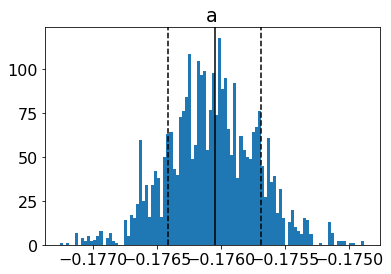

showing q = q2


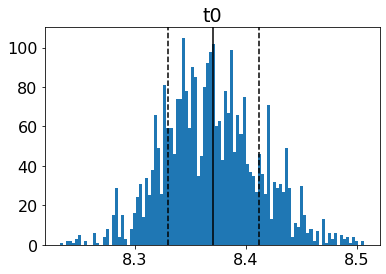

showing q = q4


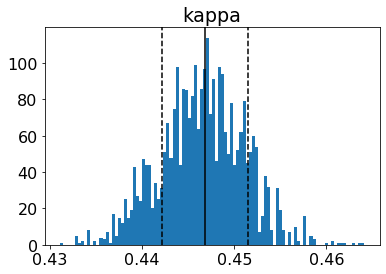

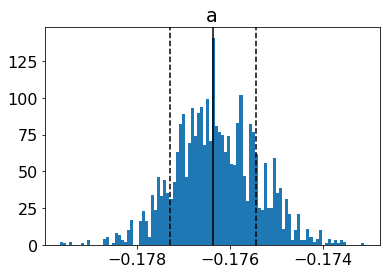

showing q = q5


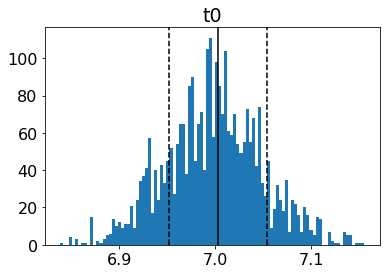

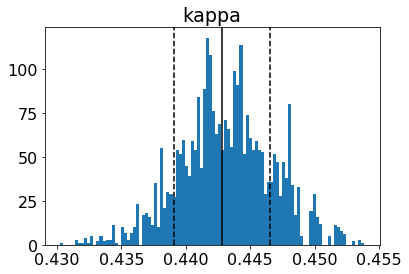

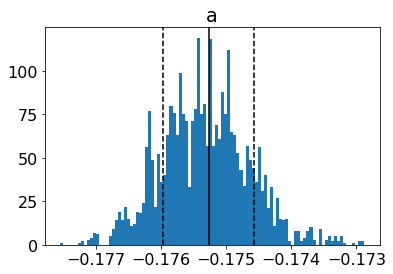

showing q = q10


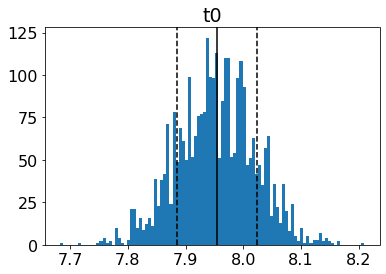

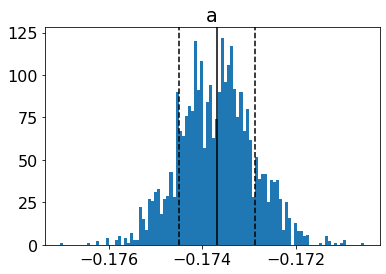

showing q = q18


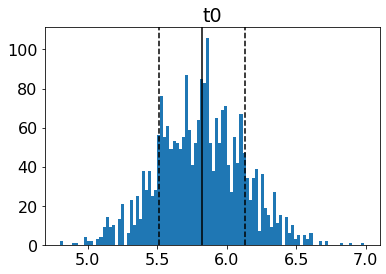

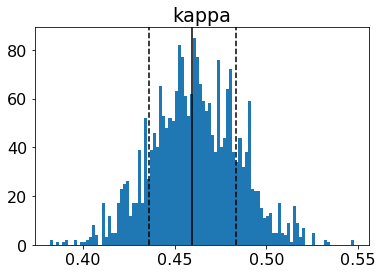

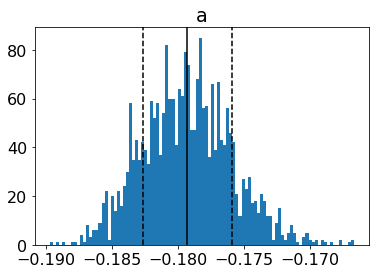

In [57]:

for k in lmfit_results.keys():
    print("showing q = {}".format(k))

    lmfit_res = lmfit_results[k]
    bil_res = bilby_results[k]

    for p in ['t0', 'kappa', 'a']:

        plt.figure()
        plt.hist(bil_res.posterior[p], bins=100);

        v = lmfit_res.result.params[p].value
        verr = lmfit_res.result.params[p].stderr

        plt.axvline(v, c='k')
        plt.axvline(v+verr, c='k', ls='--')
        plt.axvline(v-verr, c='k', ls='--')
        plt.title(p)
        plt.show()
        plt.close()